In [1]:
import skimage.measure as msr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
import pandas as pd
from PIL import Image, ImageCms

import glob
import os
from pathlib import Path
import imageio
import cv2

In [2]:
# Importing class from wmark.py
from wmark import WaterMark

In [3]:
# Source Directory
srcFolder = 'TestSet/'
# Source Path
srcPth = Path(srcFolder).resolve()

# Destination Directory
# dstFolder = Path(srcFolder+'/marked/').resolve()
# Creating folder for marked images
# Path(dstFolder).mkdir(exist_ok=True)
# Destination Path
# dstPath = Path(dstFolder).resolve()

In [4]:
# Creating empty DataFrame that will fill up after the loop
metricDataframe = pd.DataFrame()

for i in range(1, 2):
    
    # Generating random seed as integer up to 10000
    randomNums = np.random.randint(10000, size=(1))
    randomNum = randomNums[0]
    print(randomNum)

    wObject = WaterMark(randomNum)

    # All TIF files in the src_path are now imgs
    imgsSource = srcPth.glob('*.tif')
    
    # Counting the number of images in src_folder
    list = os.listdir(srcFolder)
    # -1 because there os one hidden file in directory
    numImages = len(list) - 1
    
    # Creating zeros Numpy Array and setting counter for results
    results = np.zeros([numImages, 9])
    counter = 0
        

    for img in imgsSource:
    
        # Read original image
        imgOriginal = WaterMark.imread(img)
        
        # Find impact factor within a PSNR range
        ImpactFactor = wObject.findImpactFactor(imgOriginal, rangePSNR = (35,40))
        
        # Mark image
        imgMarked = wObject.embedMark(imgOriginal, factor = ImpactFactor)
        
        
        #CROPPING
        #CROPPING
        #CROPPING
        
        # Width
        lx = imgMarked.shape[0]
        # Height
        ly = imgMarked.shape[1]
        
        # Generating cropped image
        # 1/8 from each side (result is by 1/4 smaller than original)
        imgCropped = imgMarked[lx // 8: - lx // 8, ly // 8: - ly // 8]
        
        
        #SCALING
        #SCALING
        #SCALING
        
        # Wanted value of scaled image (in pixels)
        height = 768
        width = 768
        
        # Generating scaled image
        imgScaled = cv2.resize(imgMarked, (width, height))

        
        #ROTATION
        #ROTATION
        #ROTATION
        
        # Rotation angle
        angle = 90
        
        # Defines center of image
        rows, cols = imgMarked.shape[:2]
        M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
        
        # Generating rotated image
        imgRotated = cv2.warpAffine(imgMarked, M, (cols, rows))    

        
        # AFFINE TRANSFORMATION
        # AFFINE TRANSFORMATION
        # AFFINE TRANSFORMATION
        
        # Defining points in original image
        point1a = [50, 50]
        point1b = [200, 50]
        point1c = [50, 200]
        # Defining points in transformed image
        point2a = [10, 100]
        point2b = [200, 50]
        point2c = [100, 250]
        
        rows, cols, ch = imgMarked.shape
        # Compiling original points into single array
        pts1 = np.float32([point1a, point1b, point1c])
        # Compiling transformed points into single array
        pts2 = np.float32([point2a, point2b, point2c])
        M = cv2.getAffineTransform(pts1, pts2)
        
        #Generating affined image
        imgAffined = cv2.warpAffine(imgMarked, M, (cols, rows))
       
        
        # 2D CONVOLUTION
        # 2D CONVOLUTION
        # 2D CONVOLUTION
        
        # Horizontal deviation (intensity)
        kernelX = 3
        # Vertical deviation (intensity)
        kernelY = 3
        
        kernelMultiplication = kernelX * kernelY
        kernel = np.ones((kernelX, kernelY), np.float32)/kernelMultiplication
        
        #Generating convoluted image
        imgConvoluted = cv2.filter2D(imgMarked, -1, kernel)
       
        
        # GAUSSIAN BLUR
        # GAUSSIAN BLUR
        # GAUSSIAN BLUR
        
        # Horizontal deviation (blur intensity)
        kernelX = 3
        # Vertical deviation (blur intensity)
        kernelY = 3
        
        # Generating blurred image
        imgBlurred = cv2.GaussianBlur(imgMarked, (kernelX, kernelY), cv2.BORDER_DEFAULT)
  
        
        # GAUSSIAN NOISE
        # GAUSSIAN NOISE
        # GAUSSIAN NOISE
        
        # Wanted value of rotation angle (in degrees)
        noiseAmount = 0.5
        
        # Generate Gaussian noise
        gauss = np.random.normal(0, noiseAmount, imgMarked.size)
        gauss = gauss.reshape(
            imgMarked.shape[0], imgMarked.shape[1], imgMarked.shape[2]).astype('uint8')
        
        # Generating Gaussian noised image
        imgNoised = cv2.add(imgMarked, gauss)
      
        
        metricOriginal = wObject.decodeMark(imgOriginal, 'CORR')
        results[counter, 0] = metricOriginal
        
        metricMarked = wObject.decodeMark(imgMarked, 'CORR')
        results[counter, 1] = metricMarked
        
        metricCropped = wObject.decodeMark(imgCropped, 'CORR')
        results[counter, 2] = metricCropped
        
        metricScaled = wObject.decodeMark(imgScaled, 'CORR')
        results[counter, 3] = metricScaled
        
        metricRotated = wObject.decodeMark(imgRotated, 'CORR')
        results[counter, 4] = metricRotated
        
        metricAffined = wObject.decodeMark(imgAffined, 'CORR')
        results[counter, 5] = metricAffined
        
        metricConvoluted = wObject.decodeMark(imgConvoluted, 'CORR')
        results[counter, 6] = metricConvoluted
        
        metricBlurred = wObject.decodeMark(imgBlurred, 'CORR')
        results[counter, 7] = metricBlurred
        
        metricNoised = wObject.decodeMark(imgNoised, 'CORR')
        results[counter, 8] = metricNoised
        
        counter += 1
        
        
        metricValues = ["Original", "Marked", "Cropped", "Scaled", "Rotated", "Affined", "2D Convoluted", "Blurred", "Noised"]
        metricSeeds = [f"{randomNum}", f"{randomNum}", f"{randomNum}", f"{randomNum}", f"{randomNum}", f"{randomNum}", f"{randomNum}", f"{randomNum}", f"{randomNum}"]
        
        finalMetric = pd.DataFrame(results, columns = [metricSeeds, metricValues])
    

    metricDataframe = pd.concat([metricDataframe, finalMetric], axis = 1)

780


/Users/zgebac/miniconda3/envs/img-proc/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [5]:
# Show Pandas DataFrame
metricDataframe

780                                                                  \
   Original    Marked   Cropped    Scaled   Rotated   Affined 2D Convoluted   
0  0.211862  0.800682  0.373367  0.171165  0.647133  0.225843      0.596619   
1  0.254950  0.553205  0.302978  0.265495  0.473039  0.265683      0.547819   
2  0.206330  0.912322  0.642608  0.171318  0.743723  0.256356      0.830030   
3  0.259961  0.773519  0.436646  0.221520  0.650445  0.243192      0.720208   
4  0.243063  0.916625  0.622977  0.222589  0.734404  0.239575      0.892943   

                       
    Blurred    Noised  
0  0.604603  0.654274  
1  0.549082  0.461778  
2  0.832977  0.816019  
3  0.721864  0.687511  
4  0.893897  0.880855

In [6]:
stackedDataframe = metricDataframe.stack(0)

In [7]:
stackedDataframe

,,2D Convoluted,Affined,Blurred,Cropped,Marked,Noised,Original,Rotated,Scaled
0,780,0.596619,0.225843,0.604603,0.373367,0.800682,0.654274,0.211862,0.647133,0.171165
1,780,0.547819,0.265683,0.549082,0.302978,0.553205,0.461778,0.254950,0.473039,0.265495
2,780,0.830030,0.256356,0.832977,0.642608,0.912322,0.816019,0.206330,0.743723,0.171318
3,780,0.720208,0.243192,0.721864,0.436646,0.773519,0.687511,0.259961,0.650445,0.221520
4,780,0.892943,0.239575,0.893897,0.622977,0.916625,0.880855,0.243063,0.734404,0.222589


In [8]:
describeDataframe = metricDataframe.describe()

In [9]:
describeDataframe

780                                                    \
       Original    Marked   Cropped    Scaled   Rotated   Affined   
count  5.000000  5.000000  5.000000  5.000000  5.000000  5.000000   
mean   0.235233  0.791270  0.475715  0.210417  0.649749  0.246130   
std    0.024714  0.147857  0.151145  0.039920  0.108664  0.015411   
min    0.206330  0.553205  0.302978  0.171165  0.473039  0.225843   
25%    0.211862  0.773519  0.373367  0.171318  0.647133  0.239575   
50%    0.243063  0.800682  0.436646  0.221520  0.650445  0.243192   
75%    0.254950  0.912322  0.622977  0.222589  0.734404  0.256356   
max    0.259961  0.916625  0.642608  0.265495  0.743723  0.265683   

                                         
      2D Convoluted   Blurred    Noised  
count      5.000000  5.000000  5.000000  
mean       0.717524  0.720485  0.700087  
std        0.147355  0.146233  0.162146  
min        0.547819  0.549082  0.461778  
25%        0.596619  0.604603  0.654274  
50%        0.720208  0.721864  0.687511  
75%        0.830030  0.832977  0.816019  
max        0.892943  0.893897  0.880855

In [10]:
meanDataframe = describeDataframe.iloc[1]

In [11]:
meanDataframe

780  Original         0.235233
     Marked           0.791270
     Cropped          0.475715
     Scaled           0.210417
     Rotated          0.649749
     Affined          0.246130
     2D Convoluted    0.717524
     Blurred          0.720485
     Noised           0.700087
Name: mean, dtype: float64

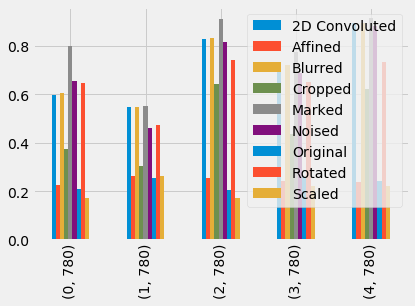

In [12]:
plt.style.use('fivethirtyeight')

stackedDataframe.plot(kind = 'bar', stacked = False, legend = True)
plt.show()

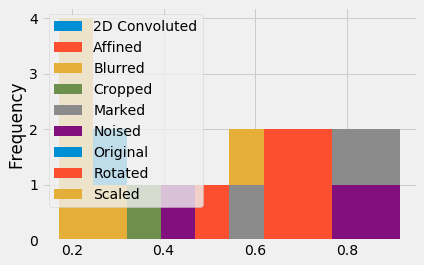

In [13]:
stackedDataframe.plot.hist(legend = True)